#  Whose Gore is it?

I will be running two more sets of models but this time to determine which forum a post comes from.  

___Table of Contents___

- [Imports](#section1)
- [Testing Environment](#section2)
- [Naive Bayes](#section3)
    - [MB with Count Vectorizer](#section3a)
    - [MB with Tfid Vectorizer](#section3b)
- [Decision Tree](#section4)

# Imports <a class="anchor" id="section1"></a>

In [2]:
import pandas as pd

#import models
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

# Import vectorizers.
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from pred_confmatrix import conf_mat

#import ensembles
from sklearn.ensemble import AdaBoostClassifier,VotingClassifier,GradientBoostingClassifier

# Testing Environment <a class="anchor" id="section2"></a>

In [3]:
df = pd.read_csv('./data/clean_sentiment.csv')
df.dropna(inplace=True)
df['subreddit']= df['subreddit'].astype('int')
df

,subreddit,source,body,sentiment,body_len,word_len
0,1,sub,slaughter of the vampires 1962 movie trailer p...,0,140,22
1,1,sub,dead earth aka two of us 2020 movie trailer pl...,0,178,34
2,1,sub,review on ready or not what dose everyone think,1,49,9
3,1,sub,new video trailer roh mati paksa indonesia 202...,1,90,13
4,1,sub,bloodshot 2020 movie trailer plot ray garrison...,1,113,17
...,...,...,...,...,...,...
4179,0,subst,i recently finished american horror story 1984...,1,158,29
4180,0,subst,we all know the horror genre has taken a backs...,1,172,34
4181,0,subst,i went over 4th of july weekend to see jurassi...,1,445,88
4182,0,subst,personally im a huge fan of both ill almost al...,1,1385,257


In [4]:
X = df['body']
y = df['subreddit']

In [5]:
#baseline
y.value_counts(normalize=True)

0    0.588812
1    0.411188
Name: subreddit, dtype: float64

In [6]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,stratify=y,random_state=42)

# Naive Bayes <a class="anchor" id="section3"></a>

## MB with Count Vectorizer <a class="anchor" id="section3a"></a>

In [14]:
mbcvec_pipe = Pipeline([
    ('cvec',CountVectorizer()),
    ('mb',MultinomialNB())
])

params = {'cvec__max_features': [2000, 3000, 4000, 5000], 
                 'cvec__min_df': [2, 3],
                 'cvec__max_df': [.9, .95],
                 'cvec__ngram_range': [(1, 1), (1, 2)],
                 'cvec__stop_words':[None,'english']}

gs = GridSearchCV(mbcvec_pipe,param_grid=params)
gs.fit(X_train,y_train)
print(gs.best_score_)
gs.best_params_

0.8045507886576088


{'cvec__max_df': 0.9,
 'cvec__max_features': 5000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 2),
 'cvec__stop_words': 'english'}

__GridSearchCV Predictions__

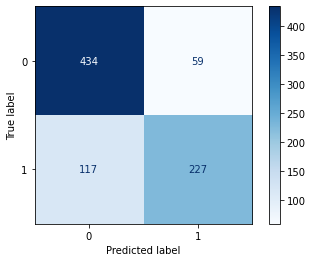

In [7]:
preds_mbcvec = gs.predict(X_test)

tn,fp,fn,tp = confusion_matrix(y_test,preds_mbcvec).ravel()
plot_confusion_matrix (gs,X_test,y_test,cmap='Blues',values_format = 'd');

In [8]:
mbcvec = conf_mat(tn,fp,fn,tp)
mbcvec.all()

Sensitivity is 0.6598837209302325
Specificity is 0.8803245436105477
Precision is 0.7937062937062938
Accuracy is 0.7897252090800478
Misclassification Rate is 0.21027479091995216


## MB with TfidVectorizer <a class="anchor" id="section3b"></a>

In [13]:
mbtvec_pipe = Pipeline([
    ('tvec',TfidfVectorizer()),
    ('mb',MultinomialNB())
])

params = {'tvec__max_features': [50, 500, 5000],
          'tvec__min_df': [2, 3],
          'tvec__max_df': [.8, .9, .95],
          'tvec__ngram_range': [(1, 1), (1, 2)],
          'tvec__stop_words':[None,'english']}

gs = GridSearchCV(mbtvec_pipe,param_grid=params)
gs.fit(X_train,y_train)
print(gs.best_score_)
gs.best_params_

0.8144153671106352


{'tvec__max_df': 0.8,
 'tvec__max_features': 5000,
 'tvec__min_df': 2,
 'tvec__ngram_range': (1, 2),
 'tvec__stop_words': 'english'}

__GridSearchCV Predictions__

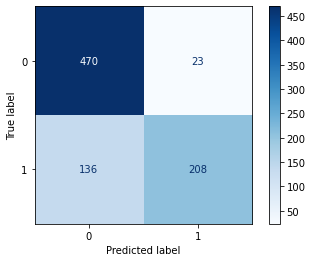

In [11]:
preds_mbtvec = gs.predict(X_test)

tn,fp,fn,tp = confusion_matrix(y_test,preds_mbtvec).ravel()
plot_confusion_matrix (gs,X_test,y_test,cmap='Blues',values_format = 'd');

In [12]:
mbtvec = conf_mat(tn,fp,fn,tp)
mbtvec.all()

Sensitivity is 0.6046511627906976
Specificity is 0.9533468559837728
Precision is 0.9004329004329005
Accuracy is 0.8100358422939068
Misclassification Rate is 0.1899641577060932


# Decision Tree <a class="anchor" id="section4"></a>
Since the TfidVectorizer perfomed better with this dataset, I used TfidVectorizer in the Decision Tree

In [15]:
vote = VotingClassifier([
    ('ada',AdaBoostClassifier()),
    ('grad_boost',GradientBoostingClassifier()),
    ('tree',DecisionTreeClassifier())
]) 


pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('vote', vote)
])

params={'tvec__max_features': [2000, 3000, 4000, 5000], 
        'tvec__min_df': [2, 3],
        'tvec__max_df': [.8,.9, .95],
        'tvec__ngram_range': [(1, 1), (1, 2)],
        'tvec__stop_words':[None,'english'],
        'vote__ada__n_estimators':[50,100,200],
        'vote__grad_boost__n_estimators':[50,100,200]
        }
gs = GridSearchCV(pipe,param_grid=params)
gs.fit(X_train,y_train)
print(gs.best_score_)
gs.best_params_

0.7872092452535528


{'tvec__max_features': 3000,
 'tvec__ngram_range': (1, 1),
 'tvec__stop_words': None,
 'vote__ada__n_estimators': 100,
 'vote__grad_boost__n_estimators': 50}

__GridSearchCV Predictions__

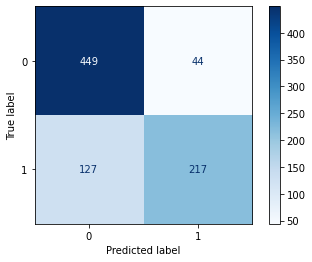

In [10]:
preds_vote = gs.predict(X_test)

tn,fp,fn,tp = confusion_matrix(y_test,preds_vote).ravel()
plot_confusion_matrix (gs,X_test,y_test,cmap='Blues',values_format = 'd');

In [11]:
vote = conf_mat(tn,fp,fn,tp)
vote.all()

Sensitivity is 0.6308139534883721
Specificity is 0.9107505070993914
Precision is 0.8314176245210728
Accuracy is 0.7956989247311828
Misclassification Rate is 0.20430107526881724
